In [182]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [183]:
df = pd.read_csv("signal-data.csv")

In [184]:
df.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [185]:
df.shape

(1567, 592)

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [187]:
df.isnull().any().any()

True

### It seems there are multiple null values in multiple features. 

In [188]:
uniqueValues = df['Pass/Fail'].unique()
target = [df.loc[df['Pass/Fail'] == val] for val in uniqueValues]

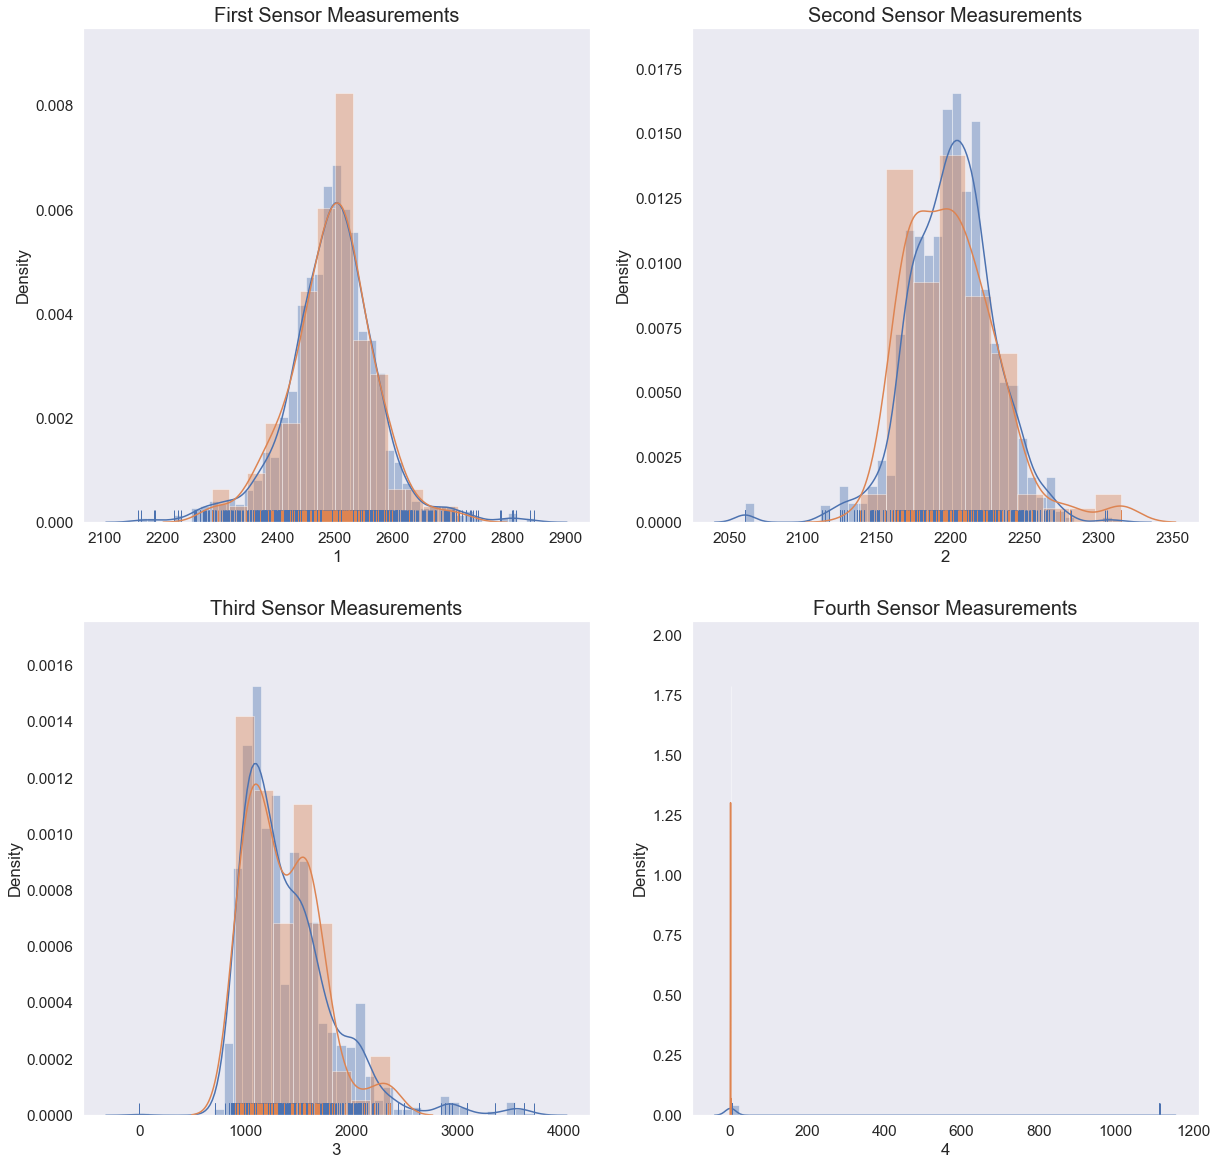

In [189]:
fig = plt.figure(figsize=(20,20))

plt.subplot(2, 2, 1)
for target in targets:
    sns.distplot(target['1'], hist=True, rug=True)
plt.title('First Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 2)
for target in targets:
    sns.distplot(target['2'], hist=True, rug=True)
plt.title('Second Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 3)
for target in targets:
    sns.distplot(target['3'], hist=True, rug=True)
plt.title('Third Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 4)
for target in targets:
    sns.distplot(target['4'], hist=True, rug=True)
plt.title('Fourth Sensor Measurements', fontsize = 20)
warnings.filterwarnings("ignore", category=FutureWarning)

### Above is the distribution for first 4 features which suggest there will be few null values and outliers too in other features too. 

##  Decision has to be made on replacing null values with either 0 or mean/median. As these features are signal information collected from sensor we can assume that the null values means absense of signal and we can replace null values with 0.

In [190]:
dfnew = df.replace(np.NaN, 0)

In [191]:
dfnew.isnull().any().any()

False

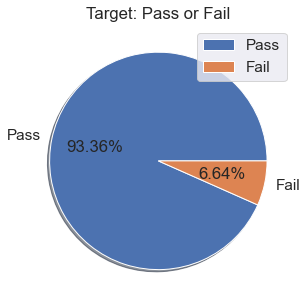

<AxesSubplot:xlabel='Pass/Fail', ylabel='count'>

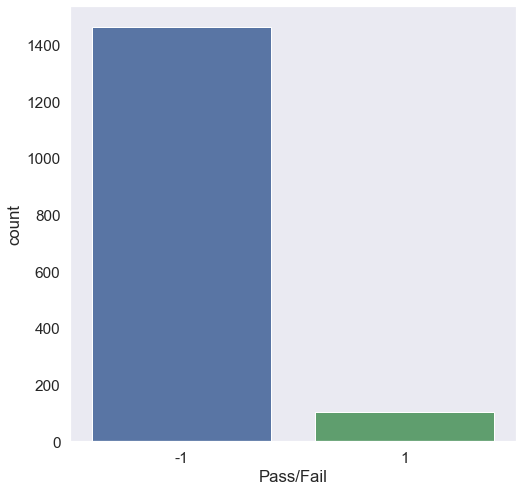

In [192]:
labels = ['Pass', 'Fail']
size = dfnew['Pass/Fail'].value_counts()

plt.subplot(1, 1, 1)
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels =labels, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail')
plt.legend()
plt.show()

sns.countplot(dfnew['Pass/Fail'])



#### In our target variable, we can see that it is not balance. 93% or more say pass and below 7% suggest pass. We will need some target balancing. 

Text(0.5, 1.0, 'Correlation for the Sensor data with heatmap')

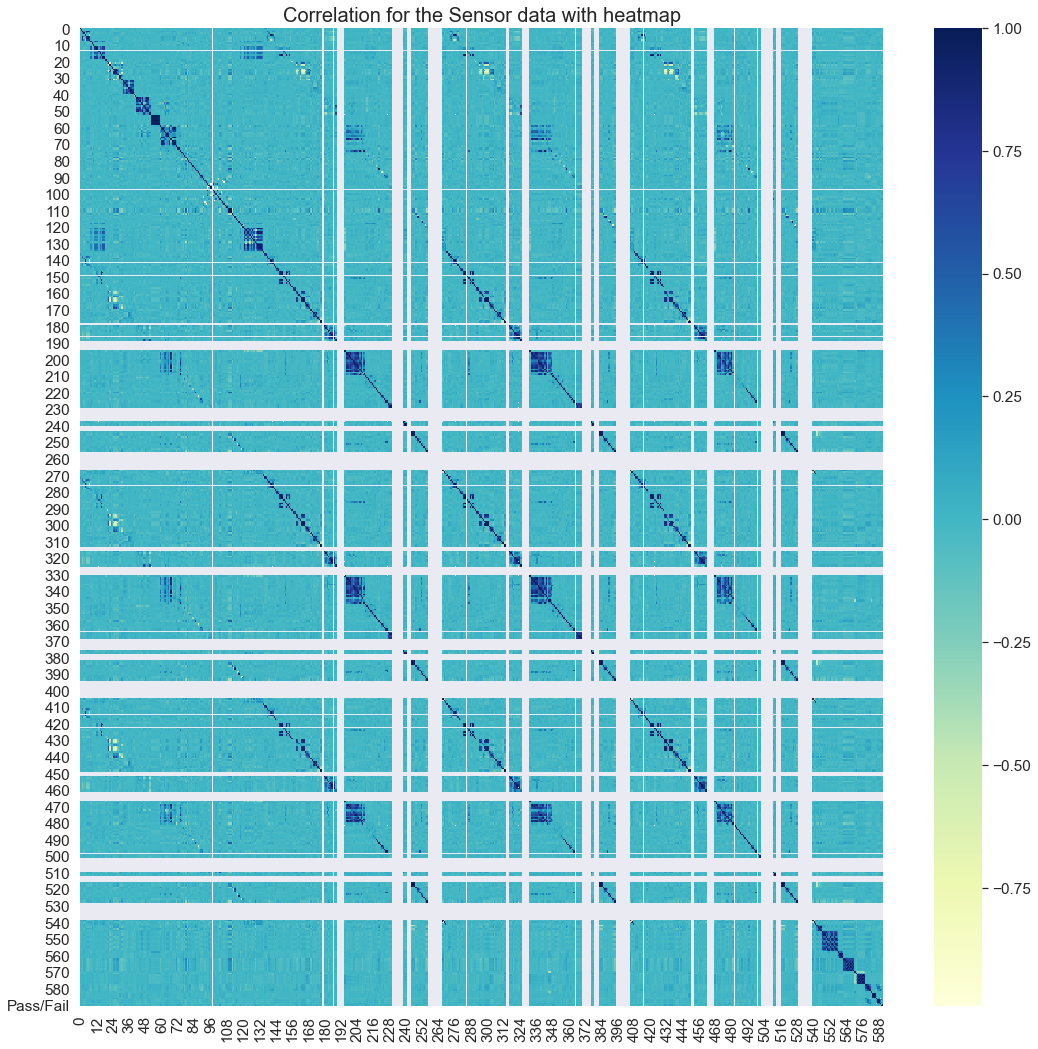

In [193]:
plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(dfnew.corr(), cmap = "YlGnBu")
plt.title('Correlation for the Sensor data with heatmap', fontsize = 20)

### From the heatmap, we can see that dark blue color suggest correlation. There are few spots on the plot that are of dark blue color. Therefore, we have some correlation among the signal values.

### To remove the correlation, we need to drop few features. We can write a python function for that.

In [194]:
correlation = dfnew.corr()

In [195]:
def rm_Corr(data, threshold):
    iters = range(len(correlation.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i+1):
            item = correlation.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            if val >= threshold:
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    drops = set(drop_cols)
    data = data.drop(columns=drops)

    return data

### We remove features with correlation more than .7

In [196]:
data = rm_Corr(dfnew,0.7)

5 | 2 | 0.99
6 | 2 | 0.82
6 | 5 | 0.84
7 | 2 | 0.75
7 | 5 | 0.77
12 | 11 | 0.83
17 | 11 | 0.81
18 | 11 | 0.72
18 | 12 | 0.79
18 | 17 | 0.9
22 | 21 | 0.75
26 | 25 | 0.83
27 | 25 | 0.98
27 | 26 | 0.79
30 | 29 | 0.86
34 | 32 | 0.88
35 | 34 | 0.83
37 | 32 | 0.75
37 | 34 | 0.75
38 | 32 | 0.72
38 | 34 | 0.72
38 | 36 | 0.71
38 | 37 | 0.97
39 | 32 | 0.81
39 | 34 | 0.91
39 | 35 | 0.71
39 | 37 | 0.86
39 | 38 | 0.84
43 | 42 | 0.82
44 | 42 | 0.82
46 | 42 | 0.84
46 | 43 | 0.84
46 | 45 | 0.74
48 | 44 | 0.77
49 | 42 | 1.0
49 | 43 | 0.82
49 | 44 | 0.82
49 | 46 | 0.84
50 | 42 | 0.88
50 | 43 | 0.9
50 | 46 | 0.97
50 | 49 | 0.88
51 | 47 | 0.71
54 | 53 | 1.0
55 | 53 | 0.95
55 | 54 | 0.95
56 | 53 | 0.98
56 | 54 | 0.97
56 | 55 | 0.96
57 | 53 | 0.97
57 | 54 | 0.96
57 | 55 | 0.98
57 | 56 | 0.99
58 | 53 | 0.93
58 | 54 | 0.93
58 | 55 | 0.92
58 | 56 | 0.96
58 | 57 | 0.94
61 | 60 | 0.88
65 | 64 | 0.85
66 | 60 | 0.97
66 | 61 | 0.84
66 | 62 | 0.75
68 | 60 | 0.85
68 | 61 | 0.87
68 | 66 | 0.85
69 | 60 | 0.96
69 | 61 |

425 | 282 | 0.87
425 | 283 | 0.96
425 | 287 | 0.97
425 | 289 | 0.86
425 | 420 | 0.88
425 | 421 | 0.95
426 | 153 | 1.0
426 | 288 | 0.99
427 | 16 | 0.89
427 | 147 | 0.82
427 | 148 | 0.95
427 | 152 | 0.91
427 | 154 | 1.0
427 | 282 | 0.82
427 | 283 | 0.95
427 | 287 | 0.91
427 | 289 | 0.99
427 | 420 | 0.83
427 | 421 | 0.97
427 | 425 | 0.88
428 | 155 | 1.0
428 | 290 | 0.96
429 | 156 | 1.0
429 | 291 | 0.99
430 | 159 | 0.87
430 | 163 | 0.83
430 | 164 | 0.88
430 | 165 | 0.85
430 | 294 | 0.89
430 | 298 | 0.84
430 | 299 | 0.87
430 | 300 | 0.85
431 | 160 | 0.81
431 | 163 | 0.81
431 | 164 | 0.85
431 | 165 | 0.81
431 | 294 | 0.72
431 | 295 | 0.83
431 | 298 | 0.83
431 | 299 | 0.85
431 | 300 | 0.82
431 | 430 | 0.9
434 | 26 | 0.77
434 | 159 | 0.71
434 | 163 | 0.88
434 | 164 | 0.9
434 | 165 | 0.86
434 | 294 | 0.75
434 | 298 | 0.89
434 | 299 | 0.89
434 | 300 | 0.86
434 | 430 | 0.95
434 | 431 | 0.93
435 | 26 | 0.77
435 | 159 | 0.71
435 | 163 | 0.84
435 | 164 | 0.91
435 | 165 | 0.87
435 | 294 | 0.75
435 | 

### Time feature doesn't do much for the outcome of our data, so we can drop it. 

In [197]:
data = data.drop('Time', axis=1)

In [198]:
data.shape

(1567, 307)

### We have already reduced our features to 307. 

### Balancing target variable with Upsampling 

In [199]:
from sklearn.utils import resample
df_majority = data[data['Pass/Fail'] == -1]
df_minority = data[data['Pass/Fail'] == 1]

df_min = resample(df_minority, replace = True, n_samples=1463, random_state=123)

df_balanced = pd.concat([df_majority, df_min])

df_balanced['Pass/Fail'].value_counts()

 1    1463
-1    1463
Name: Pass/Fail, dtype: int64

In [200]:
df_balanced.shape

(2926, 307)

# Splitting,modeling and CV on balanced data

In [201]:
x = df_balanced.drop('Pass/Fail', axis=1)
y = df_balanced['Pass/Fail']
print("Shape of x and y are ",x.shape,y.shape)

Shape of x and y are  (2926, 306) (2926,)


In [202]:
y

0      -1
1      -1
3      -1
4      -1
5      -1
       ..
49      1
929     1
186     1
1400    1
57      1
Name: Pass/Fail, Length: 2926, dtype: int64

In [203]:
#check if there are any 0s in target variable, where we replaced null values
(y==0).sum()

0

In [204]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

In [205]:
x_train.shape

(2048, 306)

In [206]:
y_train.shape

(2048,)

In [207]:
x_test.shape

(878, 306)

In [208]:
y_test.shape

(878,)

In [209]:
# standardization
from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# fitting independent data to the model
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [210]:
xgmodel = XGBClassifier()
xgmodel.fit(x_train, y_train)
y_pred = xgmodel.predict(x_test)

c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Confusion Matrix for XGBoost


<AxesSubplot:>

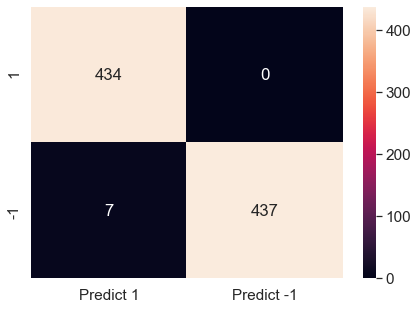

In [211]:
print("Confusion Matrix for XGBoost")
from sklearn import metrics
cm=metrics.confusion_matrix(y_test, y_pred, labels=[1, -1])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","-1"]],
                  columns = [i for i in ["Predict 1","Predict -1"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True,fmt='g')

### KNN classifier on Balanced dataset

In [212]:
from sklearn.neighbors import KNeighborsClassifier
training = []
testing = []
for k in range(1,51):
    KNN = KNeighborsClassifier(n_neighbors= k , metric = 'euclidean' ) 
    KNN.fit(x_train, y_train)
    training.append(KNN.score(x_train, y_train))
    testing.append(KNN.score(x_test, y_test))

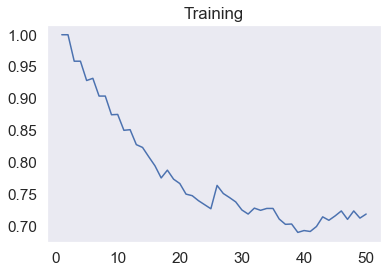

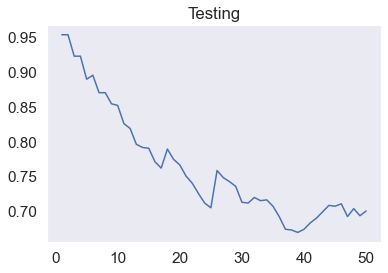

In [213]:
plt.figure(figsize=(6,4))
plt.plot(range(1,51),training)
plt.title('Training')
plt.show()
plt.figure(figsize=(6,4))
plt.plot(range(1,51),testing)
plt.title('Testing')
plt.show()

In [214]:
from sklearn.metrics import classification_report
k=[5,6,7,8,9,10,11,12,13,14,15]
for i in k:
    KNN = KNeighborsClassifier(n_neighbors=i, metric = 'euclidean' ) #Building knn with 5 neighbors
    KNN.fit(x_train, y_train)
    prediction = KNN.predict(x_test)
    print('Accuracy on Training data for k = '+str(i)+' is '+str(KNN.score(x_train, y_train)))
    print('Accuracy on Test data for k = '+str(i)+' is '+str(KNN.score(x_test, y_test)))
    print('Classification report for k '+str(i)+' :\n',classification_report(y_test,prediction))

Accuracy on Training data for k = 5 is 0.92822265625
Accuracy on Test data for k = 5 is 0.8895216400911162
Classification report for k 5 :
               precision    recall  f1-score   support

          -1       1.00      0.78      0.88       444
           1       0.82      1.00      0.90       434

    accuracy                           0.89       878
   macro avg       0.91      0.89      0.89       878
weighted avg       0.91      0.89      0.89       878

Accuracy on Training data for k = 6 is 0.931640625
Accuracy on Test data for k = 6 is 0.8952164009111617
Classification report for k 6 :
               precision    recall  f1-score   support

          -1       1.00      0.79      0.88       444
           1       0.83      1.00      0.90       434

    accuracy                           0.90       878
   macro avg       0.91      0.90      0.89       878
weighted avg       0.91      0.90      0.89       878

Accuracy on Training data for k = 7 is 0.90380859375
Accuracy on Tes

### For KNN classifier, with current data split and K = 6,  we get great accuracy of 0.88 with test data. 

In [215]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

num_folds = 50
seed = 7

kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
KNN = KNeighborsClassifier(n_neighbors=6, metric = 'euclidean' )

results = cross_val_score(KNN, x, y, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.79661017 0.89830508 0.94915254 0.93220339 0.88135593 0.94915254
 0.93220339 0.94915254 0.89830508 0.94915254 0.93220339 0.91525424
 0.88135593 0.91525424 0.93220339 0.89830508 0.88135593 0.86440678
 0.89830508 0.96610169 0.93220339 0.96610169 0.86440678 0.84745763
 0.88135593 0.96610169 0.89655172 0.87931034 0.87931034 0.9137931
 0.89655172 0.87931034 0.9137931  0.9137931  0.9137931  0.89655172
 0.96551724 0.9137931  0.87931034 0.89655172 0.93103448 0.89655172
 0.89655172 0.94827586 0.93103448 0.94827586 0.94827586 0.89655172
 0.9137931  0.94827586]
Accuracy: 91.149% (3.397%)


# Splitting,modeling and CV on original data 

In [456]:
x_org = data.drop('Pass/Fail', axis=1)
y_org = data['Pass/Fail']
print("Shape of x and y are ",x_org.shape,y_org.shape)

Shape of x and y are  (1567, 306) (1567,)


In [457]:
from sklearn.model_selection import train_test_split

x_org_train, x_org_test, y_org_train, y_org_test = train_test_split(x_org, y_org, test_size = 0.3, random_state = 1)

In [218]:
print("Shape of x and y are ",x_org_train.shape,y_org_train.shape,x_org_test.shape,y_org_test.shape)

Shape of x and y are  (1096, 306) (1096,) (471, 306) (471,)


In [219]:
from sklearn.neighbors import KNeighborsClassifier
training = []
testing = []
for k in range(1,51):
    KNN = KNeighborsClassifier(n_neighbors= k , metric = 'euclidean' ) 
    KNN.fit(x_org_train, y_org_train)
    training.append(KNN.score(x_org_train, y_org_train))
    testing.append(KNN.score(x_org_test, y_org_test))

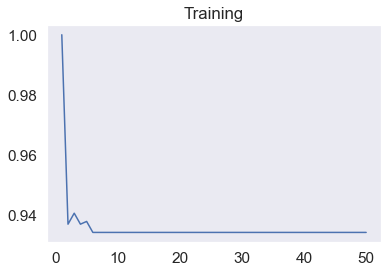

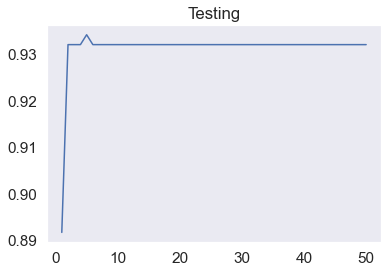

In [220]:
plt.figure(figsize=(6,4))
plt.plot(range(1,51),training)
plt.title('Training')
plt.show()
plt.figure(figsize=(6,4))
plt.plot(range(1,51),testing)
plt.title('Testing')
plt.show()

In [221]:
from sklearn.metrics import classification_report
k=[5,6,7,8,9,10,11,12,13,14,15]
for i in k:
    KNN = KNeighborsClassifier(n_neighbors=i, metric = 'euclidean' ) #Building knn with 5 neighbors
    KNN.fit(x_org_train, y_org_train)
    prediction = KNN.predict(x_org_test)
    print('Accuracy on Training data for k = '+str(i)+' is '+str(KNN.score(x_org_train, y_org_train)))
    print('Accuracy on Test data for k = '+str(i)+' is '+str(KNN.score(x_org_test, y_org_test)))
    print('Classification report for k '+str(i)+' :\n',classification_report(y_org_test,prediction))

Accuracy on Training data for k = 5 is 0.9379562043795621
Accuracy on Test data for k = 5 is 0.9341825902335457
Classification report for k 5 :
               precision    recall  f1-score   support

          -1       0.93      1.00      0.97       439
           1       1.00      0.03      0.06        32

    accuracy                           0.93       471
   macro avg       0.97      0.52      0.51       471
weighted avg       0.94      0.93      0.90       471

Accuracy on Training data for k = 6 is 0.9343065693430657
Accuracy on Test data for k = 6 is 0.9320594479830149
Classification report for k 6 :
               precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precisi

Accuracy on Training data for k = 7 is 0.9343065693430657
Accuracy on Test data for k = 7 is 0.9320594479830149
Classification report for k 7 :
               precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471

Accuracy on Training data for k = 8 is 0.9343065693430657
Accuracy on Test data for k = 8 is 0.9320594479830149
Classification report for k 8 :
               precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precisi

Accuracy on Training data for k = 9 is 0.9343065693430657
Accuracy on Test data for k = 9 is 0.9320594479830149
Classification report for k 9 :
               precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471

Accuracy on Training data for k = 10 is 0.9343065693430657
Accuracy on Test data for k = 10 is 0.9320594479830149
Classification report for k 10 :
               precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471



c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precisi

Accuracy on Training data for k = 11 is 0.9343065693430657
Accuracy on Test data for k = 11 is 0.9320594479830149
Classification report for k 11 :
               precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471

Accuracy on Training data for k = 12 is 0.9343065693430657
Accuracy on Test data for k = 12 is 0.9320594479830149


c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precisi

Classification report for k 12 :
               precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471

Accuracy on Training data for k = 13 is 0.9343065693430657
Accuracy on Test data for k = 13 is 0.9320594479830149
Classification report for k 13 :
               precision    recall  f1-score   support

          -1       0.93      1.00      0.96       439
           1       0.00      0.00      0.00        32

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471

Accuracy on Training data for k = 14 is 0.9343065693430657
Accuracy on Test data for k = 14 is 0.9320594479830149
Classification report for k 14 :
               pr

c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precisi

### On original data, although accuracy is better but F1, Recall and Precision are 0 because True Positive values are 0 for Fail. This is due to imbalance in the data set target variable.

In [222]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

num_folds = 50
seed = 7

kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
KNN = KNeighborsClassifier(n_neighbors=5, metric = 'euclidean' )

results = cross_val_score(KNN, x_org, y_org, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[1.         0.9375     0.9375     0.96875    0.9375     0.9375
 0.90625    0.96875    0.96875    1.         0.9375     0.875
 1.         0.9375     0.84375    1.         0.9375     0.93548387
 0.87096774 0.93548387 0.87096774 0.93548387 0.93548387 0.93548387
 0.93548387 0.96774194 1.         0.90322581 0.93548387 0.93548387
 0.83870968 0.87096774 0.93548387 0.87096774 0.93548387 0.80645161
 0.87096774 0.96774194 0.90322581 1.         0.96774194 0.90322581
 0.96774194 0.93548387 0.83870968 0.90322581 0.87096774 1.
 1.         1.        ]
Accuracy: 93.155% (4.932%)


Confusion Matrix


<AxesSubplot:>

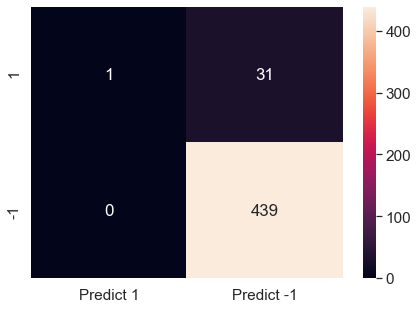

In [395]:
print("Confusion Matrix")
from sklearn import metrics
KNN.fit(x_org_train, y_org_train)
cm=metrics.confusion_matrix(y_org_test, KNN.predict(x_org_test), labels=[1, -1])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","-1"]],
                  columns = [i for i in ["Predict 1","Predict -1"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True,fmt='g')

## Bootstrap sampling on Balanced data 

In [ ]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

values= df_balanced.values
stats=list()

for i in range(10):
    train = resample(values)
    test = np.array([x for x in values if x.tolist() not in train.tolist()])
    m = KNeighborsClassifier(n_neighbors= 6 , metric = 'euclidean' )
    m.fit(train[:,:-1],train[:,-1])
    pred = m.predict(test[:,:-1])
    s = accuracy_score(test[:,-1], pred)
    print(s)
    stats.append(s)

### Leave one out Cross validation

In [ ]:
from numpy import array
from sklearn.model_selection import LeaveOneOut
values = df_balanced.values
loocv = LeaveOneOut()
# enumerate splits
for train, test in loocv.split(values):
	print(train[0])

### SMOTE to upsample smaller class

In [ ]:
from sklearn.metrics import recall_score

from imblearn.over_sampling import SMOTE

print("Before UpSampling, counts of label '1': {}".format(sum(y_org_train==1)))
print("Before UpSampling, counts of label '-1': {} \n".format(sum(y_org_train==-1)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 6, random_state=1)   #Synthetic Minority Over Sampling Technique
x_train_res, y_train_res = sm.fit_resample(x_org_train, y_org_train.ravel())

print("After UpSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After UpSampling, counts of label '-1': {} \n".format(sum(y_train_res==-1)))

print('After UpSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

# Lasso regression

In [458]:
lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_org_train,y_org_train)

y_pred = lasso.predict(x_org_test)

y_pred2 = np.sign(y_pred)

In [459]:
print("Accuracy: ", lasso.score(x_org_test,y_org_test)*100)

Accuracy:  -4.605726373489882


Confusion Matrix


<AxesSubplot:>

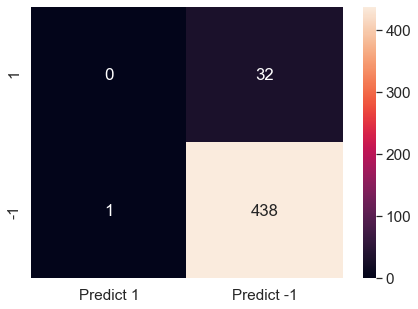

In [460]:
print("Confusion Matrix")
from sklearn import metrics
cm=metrics.confusion_matrix(y_org_test, y_pred2, labels=[1, -1])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","-1"]],
                  columns = [i for i in ["Predict 1","Predict -1"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True,fmt='g')

# Undersampling

In [461]:
fail = np.array(data[data['Pass/Fail'] == 1].index)
no_failed_tests = len(fail)

print(no_failed_tests)

104


In [462]:
passed = np.array(data[data['Pass/Fail'] == -1].index)
no_pass_tests = len(passed)

print(no_pass_tests)

1463


In [463]:
random_normal_indices = np.random.choice(no_pass_tests, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

104


In [464]:
under_sample = np.concatenate([fail, random_normal_indices])
print(len(under_sample))

208


In [465]:
undersample_data = data.iloc[under_sample, :]

In [466]:
x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(208, 306)
(208, 1)


In [467]:
from sklearn.model_selection import train_test_split

x_us_train, x_us_test, y_us_train, y_us_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_us_train.shape)
print(y_us_train.shape)
print(x_us_test.shape)
print(y_us_test.shape)

(145, 306)
(145, 1)
(63, 306)
(63, 1)


In [468]:
sc = StandardScaler()
x_train_us = sc.fit_transform(x_us_train)
x_test_us = sc.transform(x_us_test)

### XGBoost with undersampled data

In [469]:
uxgmodel = XGBClassifier(random_state=1)

uxgmodel.fit(x_us_train, y_us_train)

y_pred = uxgmodel.predict(x_us_test)

c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20:01:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


<AxesSubplot:>

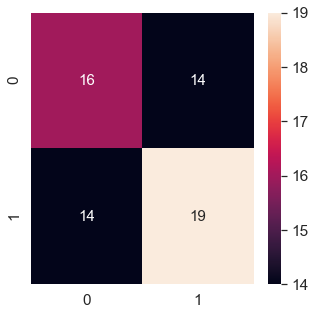

In [470]:
cm = confusion_matrix(y_us_test, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15},fmt='g')


In [472]:
print("Score: ", uxgmodel.score(x_us_test,y_us_test))

Score:  0.5555555555555556


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


# Grid search with XGBoost

In [473]:
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

grid_search = GridSearchCV(estimator = uxgmodel, param_grid = parameters, scoring = 'accuracy',  n_jobs = -1)

grid_search = grid_search.fit(x_us_train, y_us_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[20:02:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:02:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [474]:
print("Best Accuracy: ", best_accuracy*100)
print("Best Parameter: ", best_parameters)

Best Accuracy:  66.89655172413794
Best Parameter:  {'cv': 2, 'max_depth': 4, 'random_state': 1}


In [475]:
weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_us_train, y_us_train)

y_pred = model.predict(x_us_test)

[20:02:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:02:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [477]:
print("Score: ", model.score(x_us_test,y_us_test))

Score:  0.6190476190476191


<AxesSubplot:>

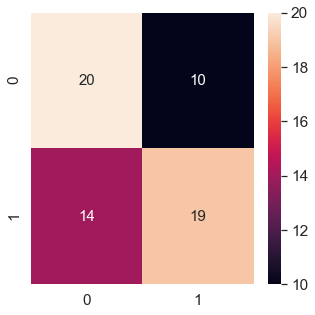

In [478]:
cm = confusion_matrix(y_us_test, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15},fmt = 'g')

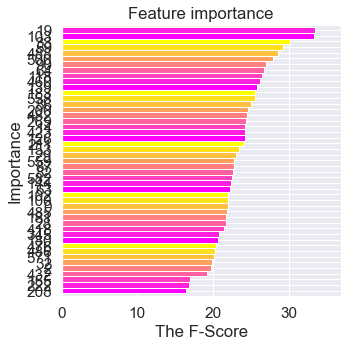

In [479]:
colors = plt.cm.spring(np.linspace(0, 1, 9))
xgb.plot_importance(model, height = 1, color = colors, grid = True, importance_type = 'cover', show_values = False)

plt.xlabel('The F-Score')
plt.ylabel('Importance')
plt.show()

### SMOTE oversampling

In [224]:
x_resample, y_resample  = SMOTE(random_state=1).fit_resample(x, y.values.ravel())

print(x_resample.shape)
print(y_resample.shape)

(2926, 306)
(2926,)


In [225]:
x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_os.shape)
print(y_train_os.shape)
print(x_test_os.shape)
print(y_test_os.shape)

(2048, 306)
(2048,)
(878, 306)
(878,)


In [226]:
sc = StandardScaler()
x_train_os = sc.fit_transform(x_train_os)
x_test_os = sc.transform(x_test_os)

### XG Boost Grid search with oversampled data 

In [227]:
oxgmodel = XGBClassifier(random_state=1)

oxgmodel.fit(x_train_os, y_train_os)

y_pred = oxgmodel.predict(x_test_os)

c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [228]:
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', n_jobs = -1)
grid_search = grid_search.fit(x_train_os, y_train_os)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:43:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [229]:
print("Best Accuracy: ", best_accuracy)
print("Best Parameter: ", best_parameters)

Best Accuracy:  0.9902343610233167
Best Parameter:  {'cv': 2, 'max_depth': 6, 'random_state': 1}


In [230]:
weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)

[14:43:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:43:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


<AxesSubplot:>

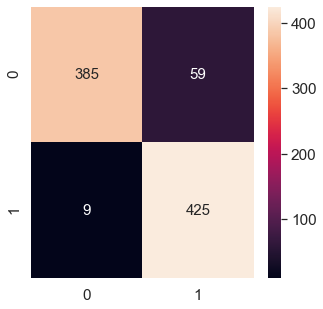

In [231]:
cm = confusion_matrix(y_test_os, y_pred)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15},fmt = 'g')

In [232]:
print("Score: ", model.score(x_test,y_test))

Score:  0.9225512528473804


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


### For KNN classifier on balanced data shows accuracy of about 88%. Lets find out if we tune hyper parameters, how can we improve the accuracy. 

In [233]:
x = df_balanced.drop('Pass/Fail', axis=1)
y = df_balanced['Pass/Fail']
print("Shape of x and y are ",x.shape,y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y,random_state = 7)

Shape of x and y are  (2926, 306) (2926,)


In [234]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [247]:
param_grid = {'n_neighbors': list(range(1,9)),
             'algorithm': ('auto', 'ball_tree', 'kd_tree' , 'brute') }

In [250]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(knn,param_grid,cv=3)

In [251]:
gs.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]})

In [252]:
gs.best_params_

{'algorithm': 'auto', 'n_neighbors': 1}

In [253]:
gs.cv_results_['params']

[{'algorithm': 'auto', 'n_neighbors': 1},
 {'algorithm': 'auto', 'n_neighbors': 2},
 {'algorithm': 'auto', 'n_neighbors': 3},
 {'algorithm': 'auto', 'n_neighbors': 4},
 {'algorithm': 'auto', 'n_neighbors': 5},
 {'algorithm': 'auto', 'n_neighbors': 6},
 {'algorithm': 'auto', 'n_neighbors': 7},
 {'algorithm': 'auto', 'n_neighbors': 8},
 {'algorithm': 'ball_tree', 'n_neighbors': 1},
 {'algorithm': 'ball_tree', 'n_neighbors': 2},
 {'algorithm': 'ball_tree', 'n_neighbors': 3},
 {'algorithm': 'ball_tree', 'n_neighbors': 4},
 {'algorithm': 'ball_tree', 'n_neighbors': 5},
 {'algorithm': 'ball_tree', 'n_neighbors': 6},
 {'algorithm': 'ball_tree', 'n_neighbors': 7},
 {'algorithm': 'ball_tree', 'n_neighbors': 8},
 {'algorithm': 'kd_tree', 'n_neighbors': 1},
 {'algorithm': 'kd_tree', 'n_neighbors': 2},
 {'algorithm': 'kd_tree', 'n_neighbors': 3},
 {'algorithm': 'kd_tree', 'n_neighbors': 4},
 {'algorithm': 'kd_tree', 'n_neighbors': 5},
 {'algorithm': 'kd_tree', 'n_neighbors': 6},
 {'algorithm': 'kd

In [254]:
gs.cv_results_['mean_test_score'].mean()

0.848393593998789

### Well clearly, with the parameter we tried to tune KNN, accuracy was lowered. Therefore, we can used default parameters where k = 6. 

# Using PCA for demensionality reduction

In [255]:
from scipy.stats import zscore
data_new=df_balanced.iloc[:,:306].apply(zscore)
data_new.head()

,0,1,2,3,4,8,9,10,11,13,...,565,570,571,572,578,582,583,586,587,589
0,0.159201,0.393890,-0.016496,0.095666,-0.035960,0.466562,1.235959,-0.432292,-0.633380,NaN,...,-1.182104,0.178032,0.077552,-0.194172,-0.700188,0.040126,-0.280752,-1.784808,-1.942951,-1.129449
1,0.569416,-0.067394,0.259319,0.225086,-0.048884,0.416117,0.074582,-1.622323,-0.009748,NaN,...,-1.182104,0.241032,1.064799,-0.236453,0.037832,0.181437,0.496218,-0.987767,0.336490,1.221167
3,-0.107802,0.001477,0.056514,-1.139391,-0.036929,0.307467,-0.752985,-0.421854,-0.002497,NaN,...,0.366558,0.000774,-0.185960,-0.188869,0.852728,-0.111278,-0.391747,-0.107700,-0.253216,-0.295763
4,0.167488,0.108656,0.278343,-0.112766,-0.031743,0.500192,-0.106231,-0.828969,-0.220043,NaN,...,-1.182104,0.078946,-0.179219,-0.195846,-0.700188,-2.029069,34.113109,-0.107700,-0.253216,-0.295763
5,-0.376450,-0.218106,0.278343,-0.112766,-0.031743,0.831319,1.270730,0.496766,0.251306,NaN,...,0.627836,0.197428,0.728056,-0.194730,1.929006,-0.525117,0.244628,1.054652,-0.230535,-0.632604


In [263]:
data_new.isnull().any().any()

True

In [264]:
data_new = data_new.replace(np.NaN, 0)

In [265]:
data_new.isnull().any().any()

False

In [335]:
x = data_new.iloc[:,:306]
y = data["Pass/Fail"]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (2926, 306)
shape of y: (1567,)


In [336]:
cov_matrix = np.cov(x.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.00034188 -0.025438    0.01190757 ...  0.02534207 -0.01274846
   0.00416579]
 [-0.025438    1.00034188 -0.02676763 ...  0.05055984  0.08770848
   0.05302504]
 [ 0.01190757 -0.02676763  1.00034188 ...  0.00498797 -0.01387241
  -0.0366611 ]
 ...
 [ 0.02534207  0.05055984  0.00498797 ...  1.00034188  0.20522929
  -0.48406676]
 [-0.01274846  0.08770848 -0.01387241 ...  0.20522929  1.00034188
   0.37949778]
 [ 0.00416579  0.05302504 -0.0366611  ... -0.48406676  0.37949778
   1.00034188]]


In [337]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[ 0.05109204 -0.00240438 -0.00310267 ...  0.          0.
   0.        ]
 [-0.00066416 -0.01138969  0.07909324 ...  0.          0.
   0.        ]
 [-0.02846881 -0.00683911  0.02015014 ...  0.          0.
   0.        ]
 ...
 [ 0.03191686  0.05578321  0.05737329 ...  0.          0.
   0.        ]
 [-0.05604537  0.0165306   0.06360841 ...  0.          0.
   0.        ]
 [-0.05858978 -0.03234809 -0.01464023 ...  0.          0.
   0.        ]]

 Eigen Values 
%s [8.42457846 5.07110017 4.45688216 4.01086658 3.79320407 3.58170739
 3.4922716  3.32726821 3.19446963 3.12023129 2.97885621 2.92302706
 2.86668405 2.70933983 2.61678078 2.55856248 2.5170468  2.43543391
 2.33970621 2.27014898 2.22569213 2.18307623 2.1240245  2.03180221
 1.99499802 1.97348727 1.92331156 1.8760089  1.82755636 1.81504539
 1.7973899  1.74679008 1.69923186 1.6548322  1.66618527 1.6801391
 1.61461596 1.6160765  1.5768682  1.56289698 1.53234796 1.51540285
 1.47628536 1.44256617 1.42992626 1.38648879 1.3579

In [338]:
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

Cumulative Variance Explained [  4.34108209   6.95415789   9.25073467  11.31748509  13.27207668
  15.11768663  16.91721141  18.63171196  20.27778303  21.88559999
  23.42056811  24.92676815  26.40393532  27.80002495  29.14842003
  30.46681594  31.76381932  33.01876858  34.22439053  35.39417049
  36.54104238  37.66595482  38.76043863  39.80740142  40.83539947
  41.85231329  42.84337217  43.81005658  44.75177399  45.68704465
  46.61321765  47.51331718  48.38891054  49.25466564  50.1132305
  50.96594526  51.79868969  52.63068151  53.44322238  54.24856405
  55.03816419  55.81903271  56.57974447  57.32308115  58.05990464
  58.77434533  59.47406037  60.16283943  60.84284687  61.5190521
  62.1914777   62.85418325  63.49941616  64.13348408  64.76229728
  65.38254718  65.98662484  66.58419638  67.17058572  67.74244551
  68.30926235  68.8613564   69.41035121  69.94991586  70.48355356
  71.01121527  71.53724423  72.05108739  72.56118366  73.06287871
  73.55622862  74.04634191  74.53143163  75.0032

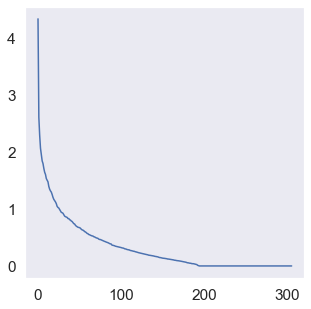

In [339]:
plt.plot(var_exp)

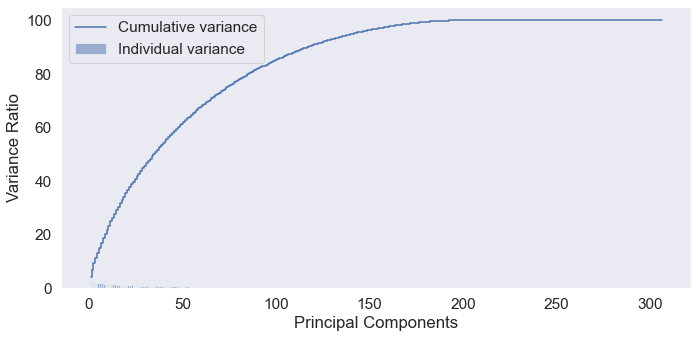

In [340]:
plt.figure(figsize=(10 , 5))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative variance')
plt.ylabel('Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [341]:
len(cum_var_exp)

306

In [342]:
from sklearn.decomposition import PCA

# NOTE - we are generating only 130 PCA dimensions (dimensionality reduction from 306 to 130)
# For 130 components we are getting approximately 90% of the variance
pca = PCA(n_components=130)
data_reduced = pca.fit_transform(x)
data_reduced.transpose()

array([[ 2.15472916,  1.05785073,  3.58454619, ...,  5.25763612,
        -5.19212871,  7.20825644],
       [ 0.55039192, -0.98919352, -0.52248383, ..., -1.16892583,
         2.06286146, -0.31515595],
       [ 0.38182276, -1.40917732,  0.24560484, ...,  5.58090098,
         2.38019057,  8.10501407],
       ...,
       [ 0.44381144,  1.56562267, -1.26784993, ..., -0.33027445,
        -0.12649176, -0.15959572],
       [-0.87625293, -0.4647281 ,  2.66480835, ...,  0.49493469,
        -0.03676213,  0.55301377],
       [-0.17614563,  0.43356002,  0.75604319, ...,  0.109897  ,
         0.25770878,  0.0452053 ]])

In [343]:
pca.components_

array([[-0.05109204,  0.00066416,  0.02846882, ..., -0.03191685,
         0.05604536,  0.05858978],
       [-0.00240445, -0.01138967, -0.00683914, ...,  0.05578324,
         0.01653063, -0.03234815],
       [-0.00310249,  0.07909312,  0.02014988, ...,  0.05737359,
         0.06360872, -0.01464036],
       ...,
       [ 0.00547923, -0.15121994,  0.02292091, ..., -0.03055962,
        -0.00560717,  0.07601924],
       [ 0.01139302, -0.02257881, -0.03664313, ...,  0.10370638,
         0.00409368, -0.03363908],
       [ 0.03730553,  0.081639  , -0.03009591, ..., -0.07205157,
        -0.10320807,  0.05696113]])

In [344]:
df_comp = pd.DataFrame(pca.components_,columns=list(x))
df_comp.head()

,0,1,2,3,4,8,9,10,11,13,...,565,570,571,572,578,582,583,586,587,589
0,-0.051092,0.000664,0.028469,-0.046378,-0.017857,0.034772,-0.041578,0.035834,-0.039983,2.005709e-19,...,-0.098520,-0.006869,0.116637,-0.026590,0.045943,-0.014630,0.021509,-0.031917,0.056045,0.058590
1,-0.002404,-0.011390,-0.006839,-0.043368,0.008921,-0.006290,-0.059747,-0.011289,0.034305,-1.353701e-18,...,0.015559,0.017587,-0.073253,-0.019067,0.067504,-0.013705,0.054184,0.055783,0.016531,-0.032348
2,-0.003102,0.079093,0.020150,-0.004108,0.028451,0.037091,0.011370,0.043583,0.028346,3.232077e-18,...,0.081480,0.035441,-0.068645,-0.016618,0.113611,0.056116,0.000826,0.057374,0.063609,-0.014640
3,-0.012542,0.022615,0.005504,0.044220,0.001087,-0.041139,-0.028699,0.057201,-0.005759,-4.559039e-18,...,0.155171,-0.003769,-0.112657,-0.003760,0.062062,-0.018170,-0.003179,0.006566,0.000452,-0.008200
4,-0.005415,-0.009578,-0.041165,-0.052304,0.003576,-0.098323,-0.028775,-0.003499,-0.167515,2.484181e-18,...,0.023196,0.026583,0.060445,0.008260,-0.023125,0.042243,0.015486,-0.009995,0.060008,0.033445


<AxesSubplot:>

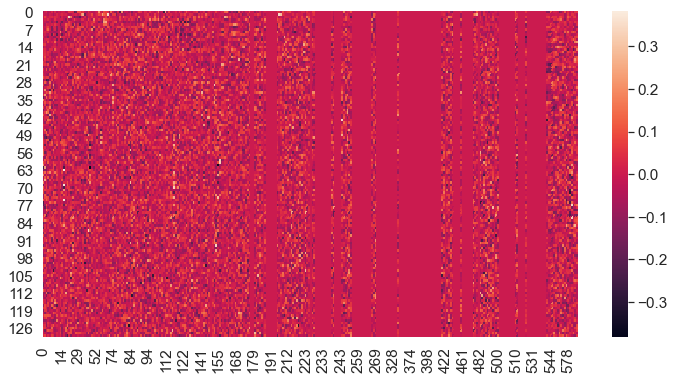

In [345]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,)

In [346]:
data_reduced.shape

(2926, 130)

In [347]:
df_red2 = pd.DataFrame(data_reduced)
df_red2.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,2.154729,0.550392,0.381823,1.914706,0.526074,-4.198569,-2.262713,-0.691745,-0.356408,-1.373574,...,-1.581583,0.388413,-0.038047,-0.631482,-0.367110,0.188025,0.766123,0.443811,-0.876253,-0.176146
1,1.057851,-0.989194,-1.409177,0.493503,0.281272,0.749317,-0.143042,-0.610978,-0.670254,0.970916,...,-1.108588,-0.310130,-0.997628,0.881204,0.987522,-1.008387,1.667700,1.565623,-0.464728,0.433560
2,3.584546,-0.522484,0.245605,1.896683,-2.460335,0.500947,0.349386,1.318289,1.766296,0.128581,...,1.150908,0.529367,1.987616,0.713832,0.966448,-0.968401,0.865793,-1.267850,2.664808,0.756043
3,2.221352,3.296262,-0.160509,-0.191046,0.305952,1.407643,-0.761274,1.620714,1.904964,-3.185656,...,-1.527524,-0.852586,0.921725,0.664925,-0.556835,1.527665,-0.438477,1.267389,0.548394,-1.593323
4,2.355209,2.536057,0.652811,0.007776,-0.591901,-1.650323,-0.691281,-0.474278,0.064392,0.600116,...,1.227084,0.152351,-1.305990,-0.564937,-0.664323,1.111552,0.523742,1.785225,0.301066,1.873102


True

In [354]:
df_red3 = df_red2.copy()
df_red3.isnull().any().any()

False

In [355]:
df_red3['Pass/Fail'] = data['Pass/Fail']

In [359]:
df_red3['Pass/Fail'].value_counts()

 1.0    1463
-1.0    1463
Name: Pass/Fail, dtype: int64

In [357]:
df_red3['Pass/Fail'] = df_red3['Pass/Fail'].replace(np.NaN, 1) 

In [358]:
df_red3.isnull().any().any()

False

array([[<AxesSubplot:title={'center':'0'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'1'}, xlabel='Pass/Fail'>],
       [<AxesSubplot:title={'center':'2'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'3'}, xlabel='Pass/Fail'>],
       [<AxesSubplot:title={'center':'4'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'5'}, xlabel='Pass/Fail'>]],
      dtype=object)

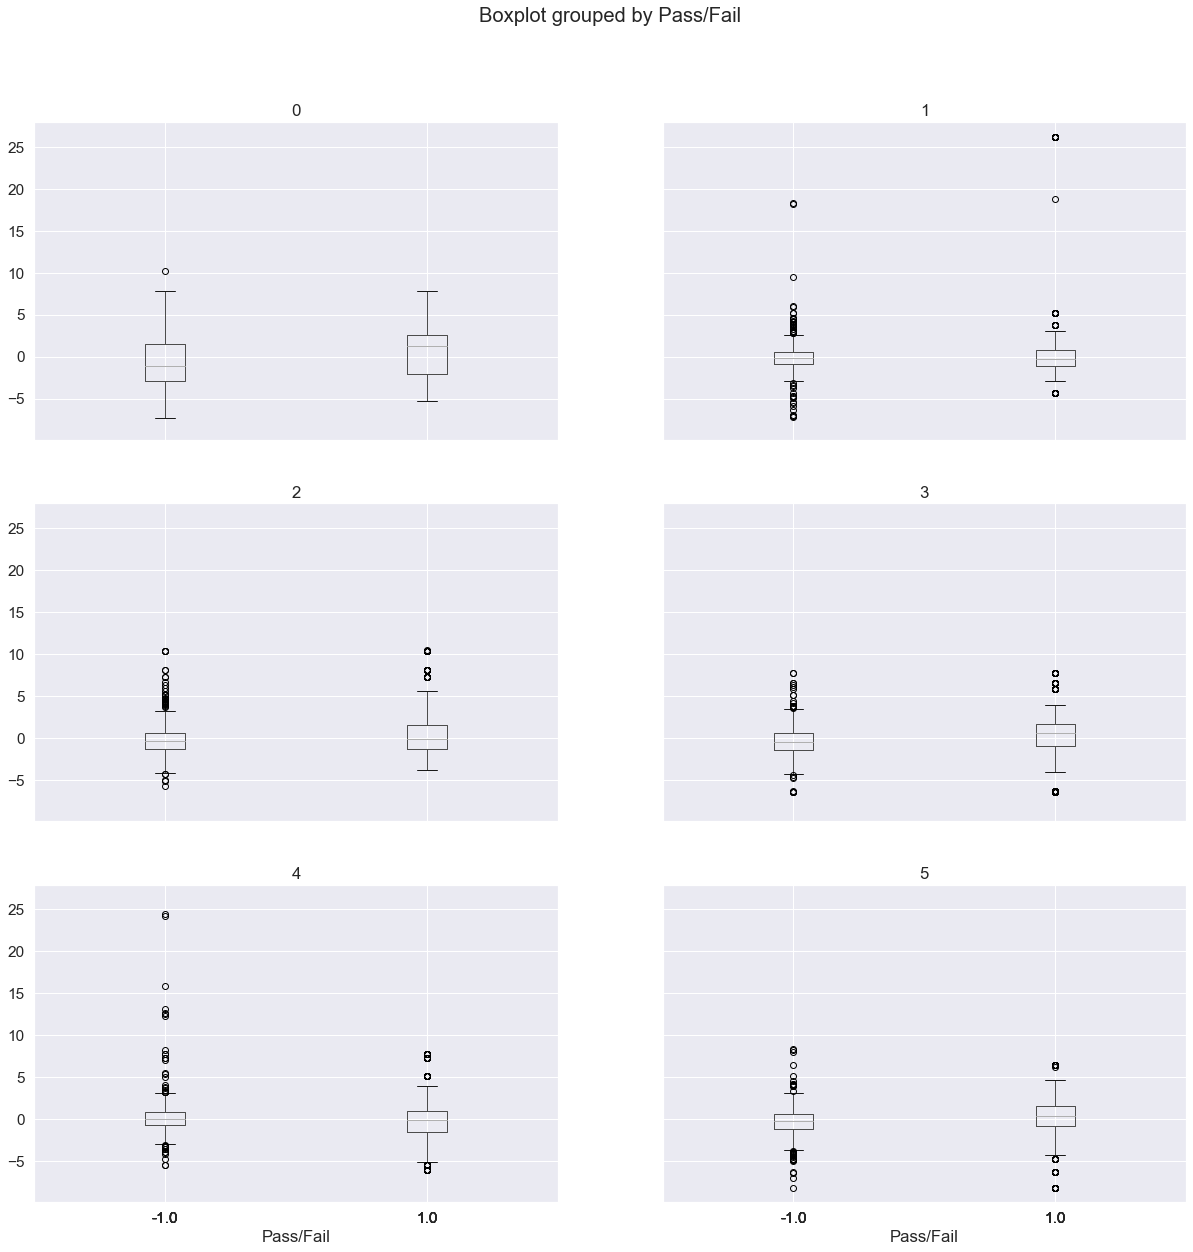

In [360]:
 df_red3.boxplot(column = [df_red3.columns[0],
                          df_red3.columns[1],
                          df_red3.columns[2],
                          df_red3.columns[3], 
                          df_red3.columns[4],
                          df_red3.columns[5],
                         ]
                          , by = 'Pass/Fail', figsize=(20,20))

### There are multiple outliers in atleast first 5 features. We need to replace them. 

In [361]:
df_red3.isnull().any().any()

False

In [362]:
newdata = df_red3.copy()

In [363]:
outliers = []
for c in newdata.columns:
    Q3 = np.percentile(newdata[c],75)
    Q1 = np.percentile(newdata[c],25)
    IQR = Q3 - Q1
    Threshold = IQR*1.5
    uf = Q3 + Threshold
    lf = Q1 - Threshold
    dfwoO = newdata.loc[(newdata[c] >= lf) & (newdata[c] <= uf)]
    mean= dfwoO[c].mean()
    newdata[c]=np.where(newdata[c]>uf,mean,newdata[c])
    newdata[c]=np.where(newdata[c]<lf,mean,newdata[c])
    #checking if there are any outliers remaining
    for i in newdata[c]:
        if i < lf or i > uf:
           outliers.append(i)
        
print(outliers)

[]


In [365]:
x = newdata.iloc[:, newdata.columns != 'Pass/Fail'] 
y = newdata.iloc[:, newdata.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(2926, 130)
(2926, 1)


In [366]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2048, 130)
(2048, 1)
(878, 130)
(878, 1)


In [372]:
model = KNeighborsClassifier(n_neighbors=6)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

c:\python\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


<AxesSubplot:>

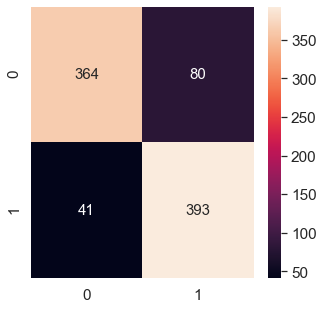

In [373]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15},fmt = 'g')

In [374]:
print("Score: ", model.score(x_test,y_test))

Score:  0.8621867881548975


# Reducing parameters helped to improve accuracy.

# XGBoost with PCA

In [375]:
xgmodel = XGBClassifier(random_state=1)

xgmodel.fit(x_train, y_train)

y_pred = xgmodel.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:29:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


<AxesSubplot:>

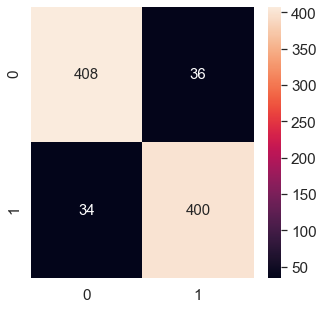

In [376]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15},fmt = 'g')

In [378]:
print("Score: ", xgmodel.score(x_test,y_test))

Score:  0.9202733485193622


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [385]:
print('Classification report for XGBoost \n',classification_report(y_test,y_pred))

Classification report for XGBoost 
               precision    recall  f1-score   support

        -1.0       0.92      0.92      0.92       444
         1.0       0.92      0.92      0.92       434

    accuracy                           0.92       878
   macro avg       0.92      0.92      0.92       878
weighted avg       0.92      0.92      0.92       878



### XGBoost is giving us better accuracy of 92%

### With Precision, Recall and F1-score of 0.92 for XGBoost. It happens to be our best bet. 

# Lets check the accuracy with PCA for all Supervised learning models possible

In [379]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
LR=LogisticRegression()
GN=GaussianNB()
KNN_model=KNeighborsClassifier(n_neighbors=6)
SVC = SVC(gamma=0.025, C=3)
xgmodel = XGBClassifier(random_state=1)
weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

In [381]:
models = []
models.append(('LR', LR))
models.append(('NB', GN))
models.append(('KNN', KNN_model))
models.append(('SVC', SVC))
models.append(('xgmodel',xgmodel))
models.append(('model',model))

In [382]:
from sklearn import model_selection
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=10,shuffle=True)
	cv = model_selection.cross_val_score(model,  x,y, cv=kfold, scoring=scoring)
	results.append(cv)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv.mean(), cv.std())
	print(msg)

c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python\lib\site-packa

LR: 0.786723 (0.023182)
NB: 0.877656 (0.016880)


c:\python\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\python\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\python\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\python\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN: 0.887556 (0.018473)


c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python\lib\site-packa

SVC: 0.929598 (0.009802)
[15:34:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The

[15:34:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


xgmodel: 0.927207 (0.010581)
[15:34:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:34:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:34:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:34:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:34:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:34:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model: 0.899178 (0.017337)


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


# Looking at accuracies we get best accuracy from XGBoost with PCA and without Grid search of 93% with standard deviation with 0.0106 which is on the lower side

In [418]:
x = data.drop('Pass/Fail', axis=1)
y = data['Pass/Fail']

In [422]:
def checkAccuracies(x,y):
    num_folds = 10
    seed = 7
    kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
    model = XGBClassifier(random_state=1)
    results = cross_val_score(model,x, y, cv=kfold)
    print(results)
    print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

In [423]:
checkAccuracies(x,y)


c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.96178344 0.94904459 0.93630573 0.92993631 0.91719745 0.94904459
 0.89808917 0.91025641 0.91666667 0.94871795]
Accuracy: 93.170% (1.961%)


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


### The achieved train and test accuracies change if a different sample population can lead to new train and test accuracies. 

# Pickle the XGBoost

In [441]:
dfnew.shape

(1567, 592)

In [444]:
dfnew = dfnew.drop('Time',axis=1)

In [445]:
x = dfnew.drop('Pass/Fail', axis=1)
y = dfnew['Pass/Fail']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

In [446]:
model = XGBClassifier(random_state=1)
model.fit(x_train, y_train)

[17:40:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [447]:
import pickle
pickle.dump(model, open(r'C:\Users\Chaitanya.Shahane\Documents\xgboost.pickle', 'wb'))

In [448]:
futuredata = pd.read_excel('Future_predictions.xlsx')

In [449]:
futuredata.replace(np.NaN, 0)

,Time,0,1,2,3,4,5,6,7,8,...,580,581,582,583,584,585,586,587,588,589
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100,97.6133,0.1242,1.5005,...,0.0000,0.0000,0.5005,0.0118,0.0035,2.3630,0.0000,0.0000,0.0000,0.0000
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100,102.3433,0.1247,1.4966,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100,95.4878,0.1241,1.4436,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100,104.2367,0.1217,1.4882,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100,100.3967,0.1235,1.5031,...,0.0000,0.0000,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432
5,2008-07-19 17:53:00,2946.25,2432.84,2233.3667,1326.5200,1.5334,100,100.3967,0.1235,1.5287,...,0.0052,44.0077,0.4949,0.0189,0.0044,3.8276,0.0342,0.0151,0.0052,44.0077
6,2008-07-19 19:44:00,3030.27,2430.12,2230.4222,1463.6606,0.8294,100,102.3433,0.1247,1.5816,...,0.0000,0.0000,0.5010,0.0143,0.0042,2.8515,0.0342,0.0151,0.0052,44.0077
7,2008-07-19 19:45:00,3058.88,2690.15,2248.9000,1004.4692,0.7884,100,106.2400,0.1185,1.5153,...,0.0063,95.0310,0.4984,0.0106,0.0034,2.1261,0.0204,0.0194,0.0063,95.0310
8,2008-07-19 20:24:00,2967.68,2600.47,2248.9000,1004.4692,0.7884,100,106.2400,0.1185,1.5358,...,0.0045,111.6525,0.4993,0.0172,0.0046,3.4456,0.0111,0.0124,0.0045,111.6525
9,2008-07-19 21:35:00,3016.11,2428.37,2248.9000,1004.4692,0.7884,100,106.2400,0.1185,1.5381,...,0.0073,90.2294,0.4967,0.0152,0.0038,3.0687,0.0212,0.0191,0.0073,90.2294


In [450]:
fdata = futuredata.drop('Time',axis=1)

In [451]:
predictions = model.predict(fdata)

c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [452]:
predictions

array([-1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,
       -1], dtype=int64)

In [453]:
fdata['Pass/Fail'] = predictions

In [454]:
fdata

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1
5,2946.25,2432.84,2233.3667,1326.5200,1.5334,100,100.3967,0.1235,1.5287,0.0167,...,44.0077,0.4949,0.0189,0.0044,3.8276,0.0342,0.0151,0.0052,44.0077,-1
6,3030.27,2430.12,2230.4222,1463.6606,0.8294,100,102.3433,0.1247,1.5816,-0.0270,...,NaN,0.5010,0.0143,0.0042,2.8515,0.0342,0.0151,0.0052,44.0077,-1
7,3058.88,2690.15,2248.9000,1004.4692,0.7884,100,106.2400,0.1185,1.5153,0.0157,...,95.0310,0.4984,0.0106,0.0034,2.1261,0.0204,0.0194,0.0063,95.0310,-1
8,2967.68,2600.47,2248.9000,1004.4692,0.7884,100,106.2400,0.1185,1.5358,0.0111,...,111.6525,0.4993,0.0172,0.0046,3.4456,0.0111,0.0124,0.0045,111.6525,-1
9,3016.11,2428.37,2248.9000,1004.4692,0.7884,100,106.2400,0.1185,1.5381,0.0159,...,90.2294,0.4967,0.0152,0.0038,3.0687,0.0212,0.0191,0.0073,90.2294,-1


### In above dataframe we can see the prediction for future data. 

# Conclusion

###  There multiple outliers in almost all features which we replaced with median of each feature.

### We have tried multiple models Logistic Regression, Random Forest, XG Boost (with and without Grid Search),OneClassSVM, etc.

### Out of all XGBoost without grid search gave great accuracy with 92% with very less Standard deviation.

### We also tried K-fold CV on KNN, XG-Boost which improved accuracies. 

### We saw that for imbalanced classes accuracy and recall are invertially proportional to each other. It affect F1, Recall and Precision due to imbalance.

###  There are few null values which does not explain whether there was no signal or sensor has malfunctioned. Here, I assumed as an absence of signal.

### There was lot of correlation between the features. After removing the correlated features, 307 features were left.

### After PCA, only 130 features were left.

### Removal of correlation and PCA has brought down features. So lot of unwanted data was present in the dataset.